In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

BOARD_ROWS = 3
BOARD_COLS = 3

In [7]:
class State:
    def __init__(self, player1, player2):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.player1 = player1
        self.player2 = player2
        self.is_end = False
        self.board_hash = None
        # El jugador 1 (IA) juega primero
        self.player_symbol = 1
    
    # Obtener un hash único del estado actual del tablero
    def get_hash(self):
        self.board_hash = str(self.board.reshape(BOARD_COLS * BOARD_ROWS))
        return self.board_hash
    
    def check_winner(self):
        # Comprobar filas
        for i in range(BOARD_ROWS):
            if sum(self.board[i, :]) == 3:
                self.is_end = True
                return 1
            if sum(self.board[i, :]) == -3:
                self.is_end = True
                return -1
        
        # Comprobar columnas
        for i in range(BOARD_COLS):
            if sum(self.board[:, i]) == 3:
                self.is_end = True
                return 1
            if sum(self.board[:, i]) == -3:
                self.is_end = True
                return -1
        
        # Comprobar diagonales
        diag_sum1 = sum([self.board[i, i] for i in range(BOARD_COLS)])
        diag_sum2 = sum([self.board[i, BOARD_COLS - i - 1] for i in range(BOARD_COLS)])
        diag_sum = max(diag_sum1, diag_sum2)
        if diag_sum == 3:
            self.is_end = True
            return 1
        if diag_sum == -3:
            self.is_end = True
            return -1
        
        # Comprobar empate (no hay posiciones disponibles)
        if len(self.available_positions()) == 0:
            self.is_end = True
            return 0
        
        # No ha terminado
        self.is_end = False
        return None
    
    def available_positions(self):
        positions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if self.board[i, j] == 0:
                    positions.append((i, j))  # Necesita ser una tupla
        return positions
    
    def update_state(self, position):
        self.board[position] = self.player_symbol
        # Cambiar al otro jugador
        self.player_symbol = -1 if self.player_symbol == 1 else 1
    
    # Solo cuando termina el juego
    def give_reward(self):
        result = self.check_winner()
        # Retropropagar la recompensa
        if result == 1:
            self.player1.feed_reward(1)
            self.player2.feed_reward(0)
        elif result == -1:
            self.player1.feed_reward(0)
            self.player2.feed_reward(1)
        else:
            self.player1.feed_reward(0.1)
            self.player2.feed_reward(0.5)
    
    # Reiniciar el tablero
    def reset(self):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.board_hash = None
        self.is_end = False
        self.player_symbol = 1
    
    def play(self, rounds=100):
        p1_wins = 0
        p2_wins = 0
        ties = 0

        p1_wins_history = []
        p2_wins_history = []
        ties_history = []

        for i in range(1, rounds + 1):
            if i % 100 == 0:
                print(f"Rounds: {i}, Player 1 wins: {p1_wins}, Player 2 wins: {p2_wins}, Ties: {ties}, porcentaje_p1_wins: {round(p1_wins / i * 100)}, porcentaje_p2_wins: {round(p2_wins / i * 100)}, porcentaje_ties: {round(ties / i * 100)}")


            while not self.is_end:
                # Player 1
                positions = self.available_positions()
                p1_action = self.player1.choose_action(positions, self.board, self.player_symbol)
                self.update_state(p1_action)
                board_hash = self.get_hash()
                self.player1.add_state(board_hash)

                win = self.check_winner()
                if win is not None:
                    if win == 1:
                        p1_wins += 1
                    elif win == -1:
                        p2_wins += 1
                    else:
                        ties += 1

                    self.give_reward()
                    self.player1.reset()
                    self.player2.reset()
                    self.reset()
                    break

                # Player 2
                positions = self.available_positions()
                p2_action = self.player2.choose_action(positions, self.board, self.player_symbol)
                self.update_state(p2_action)
                board_hash = self.get_hash()
                self.player2.add_state(board_hash)

                win = self.check_winner()
                if win is not None:
                    if win == 1:
                        p1_wins += 1
                    elif win == -1:
                        p2_wins += 1
                    else:
                        ties += 1

                    self.give_reward()
                    self.player1.reset()
                    self.player2.reset()
                    self.reset()
                    break

            # Registrar resultados por ronda
            p1_wins_history.append(p1_wins)
            p2_wins_history.append(p2_wins)
            ties_history.append(ties)

        print(f"Player 1 wins: {p1_wins}")
        print(f"Player 2 wins: {p2_wins}")
        print(f"Ties: {ties}")

        #  grafico la evolución del entrenamiento
        plt.plot(range(1, rounds + 1), p1_wins_history, label="Player 1 Wins")
        plt.plot(range(1, rounds + 1), p2_wins_history, label="Player 2 Wins")
        plt.plot(range(1, rounds + 1), ties_history, label="Ties")
        plt.xlabel("Rounds")
        plt.ylabel("Count")
        plt.legend()
        plt.title("Training Progress")
        plt.show()
    
    # Jugar contra un humano
    def play_against_human(self):
        while not self.is_end:
            # Jugador 1 (IA) siempre juega primero
            positions = self.available_positions()
            p1_action = self.player1.choose_action(positions, self.board, self.player_symbol)
            # Realizar acción y actualizar estado del tablero
            self.update_state(p1_action)
            self.show_board()
            # Comprobar si el juego ha terminado
            win = self.check_winner()
            if win is not None:
                if win == 1:
                    print(f"{self.player1.name} wins!")
                else:
                    print("Tie!")
                self.reset()
                break
            else:
                # Jugador 2
                positions = self.available_positions()
                p2_action = self.player2.choose_action(positions)
                self.update_state(p2_action)
                self.show_board()
                win = self.check_winner()
                if win is not None:
                    if win == -1:
                        print(f"{self.player2.name} wins!")
                    else:
                        print("Tie!")
                    self.reset()
                    break

    def show_board(self):
        # p1: x  p2: o
        for i in range(BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(BOARD_COLS):
                if self.board[i, j] == 1:
                    token = 'x'
                elif self.board[i, j] == -1:
                    token = 'o'
                else:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')


class Player:
    def __init__(self, name, exp_rate=0.3):
        self.name = name
        self.states = []  
        self.learning_rate = 0.2
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.states_value = {}  # estado -> valor
    
    def get_hash(self, board):
        board_hash = str(board.reshape(BOARD_COLS * BOARD_ROWS))
        return board_hash
    
    def choose_action(self, positions, current_board, symbol):
        if np.random.uniform(0, 1) <= self.exp_rate:
            # Tomar acción aleatoria
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = -999
            for position in positions:
                next_board = current_board.copy()
                next_board[position] = symbol
                next_board_hash = self.get_hash(next_board)
                value = 0 if self.states_value.get(next_board_hash) is None else self.states_value.get(next_board_hash)
                if value >= value_max:
                    value_max = value
                    action = position
        return action
    
    # añadir estado
    def add_state(self, state):
        self.states.append(state)
    
    # realimentacion del valor
    def feed_reward(self, reward):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.learning_rate * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]
    
    def reset(self):
        self.states = []
    
    # Guardar políticas
    def save_policy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()
    
    # Cargar políticas
    def load_policy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()


class HumanPlayer:
    def __init__(self, name):
        self.name = name
    
    def choose_action(self, positions):
        while True:
            row = int(input("Input your action row: "))
            col = int(input("Input your action col: "))
            action = (row, col)
            if action in positions:
                return action
    
    def add_state(self, state):
        pass
    
    def feed_reward(self, reward):
        pass
    
    def reset(self):
        pass


### Training

Entrenando...
Rounds: 100, Player 1 wins: 53, Player 2 wins: 12, Ties: 34, porcentaje_p1_wins: 53, porcentaje_p2_wins: 12, porcentaje_ties: 34
Rounds: 200, Player 1 wins: 87, Player 2 wins: 39, Ties: 73, porcentaje_p1_wins: 44, porcentaje_p2_wins: 20, porcentaje_ties: 36
Rounds: 300, Player 1 wins: 150, Player 2 wins: 57, Ties: 92, porcentaje_p1_wins: 50, porcentaje_p2_wins: 19, porcentaje_ties: 31
Rounds: 400, Player 1 wins: 221, Player 2 wins: 74, Ties: 104, porcentaje_p1_wins: 55, porcentaje_p2_wins: 18, porcentaje_ties: 26
Rounds: 500, Player 1 wins: 285, Player 2 wins: 96, Ties: 118, porcentaje_p1_wins: 57, porcentaje_p2_wins: 19, porcentaje_ties: 24
Rounds: 600, Player 1 wins: 352, Player 2 wins: 112, Ties: 135, porcentaje_p1_wins: 59, porcentaje_p2_wins: 19, porcentaje_ties: 22
Rounds: 700, Player 1 wins: 416, Player 2 wins: 124, Ties: 159, porcentaje_p1_wins: 59, porcentaje_p2_wins: 18, porcentaje_ties: 23
Rounds: 800, Player 1 wins: 475, Player 2 wins: 148, Ties: 176, porcenta

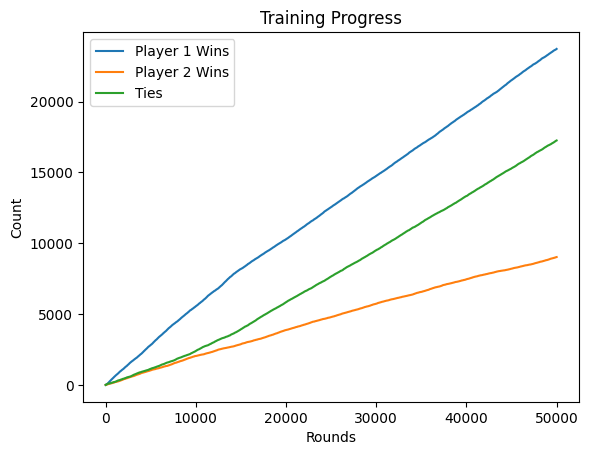

In [9]:
# Entrenamiento
p1 = Player("p1")
p2 = Player("p2")

st = State(p1, p2)
print("Entrenando...")
st.play(50000)

# guardo la politica aprendida
p1.save_policy()

    


# jugar contra humano

In [ ]:
p1 = Player("computer", exp_rate=0)
p1.load_policy("policy_p1")

p2 = HumanPlayer("human")

st = State(p1, p2)
st.play_against_human()